In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
! pip install git+https://github.com/facebookresearch/segment-anything.git
!pip install -q git+https://github.com/huggingface/transformers.git
!pip install datasets
!pip install -q monai
!pip install patchify

  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-8fiedivh
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-8fiedivh
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done
  Created wheel for segment-anything: filename=segment_anything-1.0-py3-none-any.whl size=36590 sha256=c88f0f501b5d299314987dbb5d7aca0bcb406e51da903939cc175cee0bcd8f5c
  Stored in directory: /tmp/pip-ephem-wheel-cache-p3u7zl3g/wheels/10/cf/59/9ccb2f0a1bcc81d4fbd0e501680b5d088d690c6cfbc02dc99d
Successfully built segment-anything
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116

In [140]:
import numpy as np
import glob ,os
import cv2
import matplotlib.pyplot as plt
from patchify import patchify
import random
from scipy import ndimage
from datasets import Dataset
from PIL import Image
import random
import torch
from transformers import SamModel, SamConfig, SamProcessor


Converting Images into numpy arrays


In [4]:
imgfolder='/content/drive/MyDrive/fabric_sam/train/images'
img=sorted(glob.glob(imgfolder+'/*.jpg'))
imgarr=[]
for i in img:
  im=cv2.imread(i)
  imgarr.append(im)
images=np.array(imgarr)
images.shape

(309, 360, 640, 3)

In [5]:
imgname=os.listdir(imgfolder)
imgname=sorted(imgname)

In [6]:
maskfolder='/content/drive/MyDrive/fabric_sam/train/masks'
mask=sorted(glob.glob(maskfolder+'/*.jpg'))
maskarr=[]
for i in mask:
  mas=cv2.imread(i)
  maskarr.append(mas)
masks=np.array(maskarr)

In [7]:
maskname=os.listdir(maskfolder)
maskname=sorted(maskname)

In [8]:
masks.shape

(309, 360, 640, 3)

Creating Dataset

In [9]:
data={
    "image":[Image.fromarray(imag) for imag in images],
    "masks":[Image.fromarray(mas) for mas in masks],
}


In [10]:
dataset = Dataset.from_dict(data)

In [11]:
dataset

Dataset({
    features: ['image', 'masks'],
    num_rows: 309
})

Checking that images and masks are properly mapped

ImageName: hole_46_original(3).jpg
MaskName: hole_46_original(3).jpg


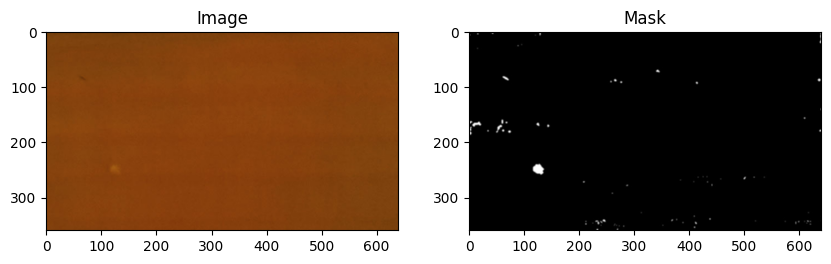

In [13]:

img_num = random.randint(0, images.shape[0]-1)
testimage = dataset[img_num]["image"]
testmask = dataset[img_num]["masks"]

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

print(f"ImageName: {imgname[img_num]}")
axes[0].imshow(np.array(testimage))
axes[0].set_title("Image")

print(f"MaskName: {maskname[img_num]}")
axes[1].imshow(testmask, cmap='gray')
axes[1].set_title("Mask")

plt.show()


Obtaining Bounding Box to feed in as a prompt to SAM Model

In [ ]:
# #obtaining bounding boxes from mask
# this function to obtain bounding box does not work because the ground truth i.e. defects are highly fragmented in it
# this could have been useful in images with fewer instances. also since dividing these images into patches would not yeild much as the fucntion would still need to return 100s of boxes in each patch
# def promptbox(mask)
#   y,x=np.where(mask>0)#marks all the white portion depecting the defect
#   ymax=np.max(y)
#   xmax=np.max(x)
#   ymin=np.min(y)
#   xmin=np.min(x)
#   # to ensure a greater range
#   h,w=mask.shape
#   xmin = max(0, xmin - np.random.randint(0, 20))
#   xmax = min(w, xmax + np.random.randint(0, 20))
#   ymin = max(0, ymin - np.random.randint(0, 20))
#   ymax = min(h, ymax + np.random.randint(0, 20))
#   box=[xmin,ymin,xmax,ymax]
#   return box


In [14]:
# function to cluster minutr defects and reduce number of bounding boxes
#even after applying morphological dilation it gives around 30 boxes in the example mask
# since these boxes would act as a prompt so they could be reduced even further


def promptbox(mask):
    if len(mask.shape) == 3:
        mask = cv2.cvtColor(mask, cv2.COLOR_RGB2GRAY)
    mask = mask.astype(np.uint8)
    _, binary_mask = cv2.threshold(mask, 1, 255, cv2.THRESH_BINARY)
    kernel = np.ones((5, 5), np.uint8)
    dilated_mask = cv2.dilate(binary_mask, kernel, iterations=2)
    contours, _ = cv2.findContours(dilated_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    bounding_boxes = []

    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)


        padding = np.random.randint(0, 20)
        xmin = max(0, x - padding)
        ymin = max(0, y - padding)
        xmax = min(mask.shape[1], x + w + padding)
        ymax = min(mask.shape[0], y + h + padding)

        bounding_boxes.append([xmin, ymin, xmax, ymax])

    return bounding_boxes

example_mask_array = masks[0]
bounding_boxes = promptbox(example_mask_array)
for i, bbox in enumerate(bounding_boxes):
    print(f"Bounding Box {i+1}: {bbox}")


Bounding Box 1: [268, 338, 301, 360]
Bounding Box 2: [152, 335, 201, 360]
Bounding Box 3: [501, 326, 547, 360]
Bounding Box 4: [215, 326, 290, 360]
Bounding Box 5: [0, 322, 86, 360]
Bounding Box 6: [78, 325, 139, 360]
Bounding Box 7: [309, 317, 522, 360]
Bounding Box 8: [538, 290, 640, 360]
Bounding Box 9: [0, 290, 29, 358]
Bounding Box 10: [528, 265, 568, 303]
Bounding Box 11: [379, 275, 437, 325]
Bounding Box 12: [329, 257, 391, 319]
Bounding Box 13: [491, 259, 533, 301]
Bounding Box 14: [0, 213, 27, 306]
Bounding Box 15: [0, 179, 13, 206]
Bounding Box 16: [252, 156, 284, 188]
Bounding Box 17: [0, 146, 15, 167]
Bounding Box 18: [0, 88, 21, 144]
Bounding Box 19: [159, 85, 196, 132]
Bounding Box 20: [25, 55, 121, 144]
Bounding Box 21: [108, 29, 147, 68]
Bounding Box 22: [458, 26, 487, 55]
Bounding Box 23: [425, 17, 470, 63]
Bounding Box 24: [501, 4, 555, 52]
Bounding Box 25: [356, 4, 428, 84]
Bounding Box 26: [591, 0, 640, 49]
Bounding Box 27: [121, 8, 160, 40]
Bounding Box 28: [400, 0

In [15]:


def promptbox(mask):
    if len(mask.shape) == 3:
        mask = cv2.cvtColor(mask, cv2.COLOR_RGB2GRAY)
    blurred_mask = cv2.GaussianBlur(mask, (3, 3), 0)
    _, binary_mask = cv2.threshold(blurred_mask, 1, 255, cv2.THRESH_BINARY)
    kernel = np.ones((3, 3), np.uint8)
    closed_mask = cv2.morphologyEx(binary_mask, cv2.MORPH_CLOSE, kernel)
    contours, _ = cv2.findContours(closed_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    bounding_boxes = []

    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        if cv2.contourArea(contour) < 100: 
            continue
        padding = np.random.randint(0, 10)
        xmin = max(0, x - padding)
        ymin = max(0, y - padding)
        xmax = min(mask.shape[1], x + w + padding)
        ymax = min(mask.shape[0], y + h + padding)

        bounding_boxes.append([xmin, ymin, xmax, ymax])

    return bounding_boxes

example_mask_array = masks[0]
bounding_boxes = promptbox(example_mask_array)
for i, bbox in enumerate(bounding_boxes):
    print(f"Bounding Box {i+1}: {bbox}")


Bounding Box 1: [318, 348, 342, 360]
Bounding Box 2: [25, 349, 50, 360]
Bounding Box 3: [626, 330, 640, 360]
Bounding Box 4: [0, 230, 12, 296]
Bounding Box 5: [255, 155, 283, 188]
Bounding Box 6: [42, 89, 112, 131]
Bounding Box 7: [0, 50, 17, 81]
Bounding Box 8: [67, 36, 104, 59]
Bounding Box 9: [375, 28, 410, 62]
Bounding Box 10: [32, 21, 54, 51]
Bounding Box 11: [131, 13, 149, 33]
Bounding Box 12: [69, 5, 121, 43]
Bounding Box 13: [60, 0, 106, 16]
Bounding Box 14: [0, 0, 14, 45]


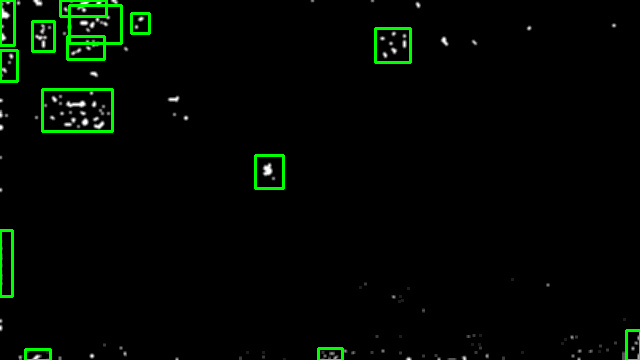

In [16]:
from google.colab.patches import cv2_imshow
import cv2
import numpy as np

example_mask_array = masks[0]
if len(example_mask_array.shape) == 2:
    mask_with_boxes = cv2.cvtColor(example_mask_array, cv2.COLOR_GRAY2BGR)
else:
    mask_with_boxes = example_mask_array.copy()

for bbox in bounding_boxes:
    xmin, ymin, xmax, ymax = bbox
    cv2.rectangle(mask_with_boxes, (xmin, ymin), (xmax, ymax), (0, 255, 0), 2)  

# Display the mask with bounding boxes
cv2_imshow(mask_with_boxes)

Dataset Preparation

In [ ]:
from torch.utils.data import Dataset

class SAMDataset(Dataset):
  """
  This class is used to create a dataset that serves input images and masks.
  It takes a dataset and a processor as input and overrides the __len__ and __getitem__ methods of the Dataset class.
  """
  def __init__(self, dataset, processor):
    self.dataset = dataset
    self.processor = processor

  def __len__(self):
    return len(self.dataset)

  def __getitem__(self, idx):
    item = self.dataset[idx]
    image = item["image"]
    ground_truth_mask = np.array(item["masks"])

    prompt = promptbox(ground_truth_mask)

    inputs = self.processor(image, input_boxes=[[prompt]], return_tensors="pt")

    inputs = {k:v.squeeze(0) for k,v in inputs.items()}

    inputs["ground_truth_mask"] = ground_truth_mask

    return inputs

In [18]:

from transformers import SamProcessor
processor = SamProcessor.from_pretrained("facebook/sam-vit-base")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/466 [00:00<?, ?B/s]

In [19]:

train_dataset = SAMDataset(dataset=dataset, processor=processor)

Create a DataLoader instance for the training dataset

In [24]:
from torch.utils.data import DataLoader
from torchvision import transforms
from PIL import Image

def custom_collate_fn(batch):
    imgs = [transforms.ToPILImage()(item['pixel_values']) for item in batch]
    masks = [transforms.ToPILImage()(item['ground_truth_mask']) for item in batch]
    input_boxes = [item['input_boxes'] for item in batch]
    max_size_img = max(img.size for img in imgs)
    max_size_mask = max(mask.size for mask in masks)

    padded_imgs = []
    padded_masks = []
    for img, mask in zip(imgs, masks):
        pad_width = (0, max_size_img[0] - img.size[0], 0, max_size_img[1] - img.size[1])
        padded_img = transforms.functional.pad(img, pad_width, fill=0)
        padded_imgs.append(padded_img)

        pad_width = (0, max_size_mask[0] - mask.size[0], 0, max_size_mask[1] - mask.size[1])
        padded_mask = transforms.functional.pad(mask, pad_width, fill=0)
        padded_masks.append(padded_mask)

    padded_imgs_tensor = torch.stack([transforms.ToTensor()(img) for img in padded_imgs])
    padded_masks_tensor = torch.stack([transforms.ToTensor()(mask) for mask in padded_masks])

    batch_dict = []
    for i in range(len(batch)):
        item_dict = {
            'pixel_values': padded_imgs_tensor[i],
            'ground_truth_mask': padded_masks_tensor[i],
            'input_boxes': input_boxes[i]
        }
        batch_dict.append(item_dict)

    return batch_dict

train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True, drop_last=False, collate_fn=custom_collate_fn)
batch = next(iter(train_dataloader))

for item in batch:
    for k, v in item.items():
        print(k, v.shape)


pixel_values torch.Size([3, 1024, 1024])
ground_truth_mask torch.Size([3, 360, 640])
input_boxes torch.Size([56, 4])
pixel_values torch.Size([3, 1024, 1024])
ground_truth_mask torch.Size([3, 360, 640])
input_boxes torch.Size([7, 4])


In [29]:
from torch.utils.data import DataLoader
from torchvision import transforms
from PIL import Image

def custom_collate_fn(batch):
    pixel_values_list = []
    ground_truth_mask_list = []

    for item in batch:
        pixel_values_list.append(transforms.ToPILImage()(item['pixel_values']))
        ground_truth_mask_list.append(transforms.ToPILImage()(item['ground_truth_mask']))

    max_size_img = max(img.size for img in pixel_values_list)
    max_size_mask = max(mask.size for mask in ground_truth_mask_list)

    padded_pixel_values = []
    padded_ground_truth_masks = []
    for img, mask in zip(pixel_values_list, ground_truth_mask_list):
        pad_width = (0, max_size_img[0] - img.size[0], 0, max_size_img[1] - img.size[1])
        padded_pixel_values.append(transforms.functional.pad(img, pad_width, fill=0))

        pad_width = (0, max_size_mask[0] - mask.size[0], 0, max_size_mask[1] - mask.size[1])
        padded_ground_truth_masks.append(transforms.functional.pad(mask, pad_width, fill=0))

    return {
        "pixel_values": torch.stack([transforms.ToTensor()(img) for img in padded_pixel_values]),
        "original_sizes": torch.tensor([img.size for img in pixel_values_list]),
        "reshaped_input_sizes": torch.tensor([img.size for img in padded_pixel_values]),
        "input_boxes": torch.zeros(len(batch), 1, 4), 
        "ground_truth_mask": torch.stack([transforms.ToTensor()(mask) for mask in padded_ground_truth_masks])
    }

train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True, drop_last=False, collate_fn=custom_collate_fn)


In [30]:
batch = next(iter(train_dataloader))
for k,v in batch.items():
  print(k,v.shape)

pixel_values torch.Size([2, 3, 1024, 1024])
original_sizes torch.Size([2, 2])
reshaped_input_sizes torch.Size([2, 2])
input_boxes torch.Size([2, 1, 4])
ground_truth_mask torch.Size([2, 3, 360, 640])


In [31]:

from transformers import SamModel
model = SamModel.from_pretrained("facebook/sam-vit-base")

for name, param in model.named_parameters():
  if name.startswith("vision_encoder") or name.startswith("prompt_encoder"):
    param.requires_grad_(False)

config.json:   0%|          | 0.00/6.57k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/375M [00:00<?, ?B/s]

In [32]:
from torch.optim import Adam
import monai
optimizer = Adam(model.mask_decoder.parameters(), lr=1e-5, weight_decay=0)
seg_loss = monai.losses.DiceCELoss(sigmoid=True, squared_pred=True, reduction='mean')

In [36]:
from tqdm import tqdm
from statistics import mean
import torch

num_epochs = 20

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

model.train()
for epoch in range(num_epochs):
    epoch_losses = []
    for batch in tqdm(train_dataloader):
      
        outputs = model(pixel_values=batch["pixel_values"].to(device),
                        input_boxes=batch["input_boxes"].to(device),
                        multimask_output=False)

        batch_loss = []
        for i in range(len(batch["ground_truth_mask"])):
            predicted_masks = outputs.pred_masks[i].squeeze(0)
            ground_truth_masks = batch["ground_truth_mask"][i][:1].float().to(device) 

            ground_truth_masks_resized = torch.nn.functional.interpolate(
                ground_truth_masks.unsqueeze(0),
                size=predicted_masks.shape[-2:],
                mode='bilinear',
                align_corners=False
            ).squeeze(0)

            loss = seg_loss(predicted_masks, ground_truth_masks_resized)
            batch_loss.append(loss)

        mean_loss = torch.mean(torch.stack(batch_loss))

        optimizer.zero_grad()
        mean_loss.backward()

        optimizer.step()
        epoch_losses.append(mean_loss.item())

    print(f'EPOCH: {epoch}')
    print(f'Mean loss: {mean(epoch_losses)}')


100%|██████████| 155/155 [02:56<00:00,  1.14s/it]


EPOCH: 0
Mean loss: 17.168595469382502


100%|██████████| 155/155 [02:47<00:00,  1.08s/it]


EPOCH: 1
Mean loss: 17.068188931095985


100%|██████████| 155/155 [02:46<00:00,  1.08s/it]


EPOCH: 2
Mean loss: 17.048276672055643


100%|██████████| 155/155 [02:47<00:00,  1.08s/it]


EPOCH: 3
Mean loss: 17.01434473991394


100%|██████████| 155/155 [02:47<00:00,  1.08s/it]


EPOCH: 4
Mean loss: 16.93943942900627


100%|██████████| 155/155 [02:47<00:00,  1.08s/it]


EPOCH: 5
Mean loss: 16.834750007813977


100%|██████████| 155/155 [02:47<00:00,  1.08s/it]


EPOCH: 6
Mean loss: 16.864211934612644


100%|██████████| 155/155 [02:47<00:00,  1.08s/it]


EPOCH: 7
Mean loss: 17.14863083977853


100%|██████████| 155/155 [02:47<00:00,  1.08s/it]


EPOCH: 8
Mean loss: 16.815080305837817


100%|██████████| 155/155 [02:46<00:00,  1.08s/it]


EPOCH: 9
Mean loss: 16.723975527671076


100%|██████████| 155/155 [02:46<00:00,  1.08s/it]


EPOCH: 10
Mean loss: 16.689955393729672


100%|██████████| 155/155 [02:47<00:00,  1.08s/it]


EPOCH: 11
Mean loss: 16.605089514486252


100%|██████████| 155/155 [02:47<00:00,  1.08s/it]


EPOCH: 12
Mean loss: 16.603033474952944


100%|██████████| 155/155 [02:47<00:00,  1.08s/it]


EPOCH: 13
Mean loss: 16.575511149437197


100%|██████████| 155/155 [02:47<00:00,  1.08s/it]


EPOCH: 14
Mean loss: 16.589415954774427


100%|██████████| 155/155 [02:46<00:00,  1.08s/it]


EPOCH: 15
Mean loss: 16.793843327030057


100%|██████████| 155/155 [02:47<00:00,  1.08s/it]


EPOCH: 16
Mean loss: 16.779564739042712


100%|██████████| 155/155 [02:46<00:00,  1.08s/it]


EPOCH: 17
Mean loss: 16.528165843409877


100%|██████████| 155/155 [02:47<00:00,  1.08s/it]


EPOCH: 18
Mean loss: 16.50033547032264


100%|██████████| 155/155 [02:47<00:00,  1.08s/it]

EPOCH: 19
Mean loss: 16.384689557936884


In [37]:
torch.save(model.state_dict(),"/content/drive/MyDrive/fabric_sam/train/model/20epochs_checkpoin.pth")

Inference

### 20 EPOCHS

In [ ]:
# Load the model configuration
model_config = SamConfig.from_pretrained("facebook/sam-vit-base")
processor = SamProcessor.from_pretrained("facebook/sam-vit-base")

# Create an instance of the model architecture with the loaded configuration
fabricmodel = SamModel(config=model_config)
#Update the model by loading the weights from saved file.
fabricmodel.load_state_dict(torch.load("/content/drive/MyDrive/fabric_sam/train/model/20epochs_checkpoin.pth"))

In [ ]:
# set the device to cuda if available, otherwise use cpu
device = "cuda" if torch.cuda.is_available() else "cpu"
fabricmodel.to(device)

190


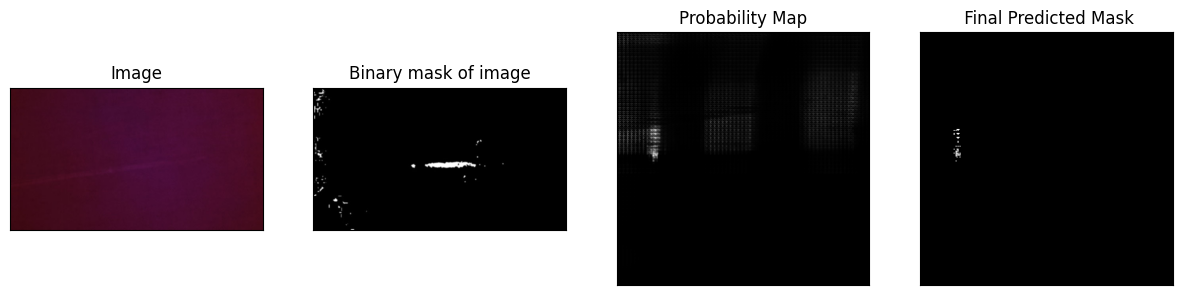

In [139]:
import random
import matplotlib.pyplot as plt

# Let's take a random training example
idx = random.randint(0, images.shape[0] - 1)
print (idx)

# Load the image
test_image = dataset[idx]["image"]
true_mask = dataset[idx]["masks"]  # Assuming the key for the true mask is "mask"

# Get the box prompt based on the ground truth segmentation map
ground_truth_mask = np.array(dataset[idx]["masks"])
prompt = promptbox(ground_truth_mask)

# Prepare the image + box prompt for the model
inputs = processor(test_image, input_boxes=[[prompt]], return_tensors="pt")

# Move the input tensor to the GPU if it's not already there
inputs = {k: v.to(device) for k, v in inputs.items()}

fabricmodel.eval()

# Forward pass
with torch.no_grad():
    outputs = fabricmodel(**inputs, multimask_output=False)

# Apply sigmoid
prob = torch.sigmoid(outputs.pred_masks.squeeze(1))
# Convert soft mask to hard mask
prob = prob.cpu().numpy().squeeze()
seg = (prob > 0.5).astype(np.uint8)

# Ensure seg is a 2D grayscale image
if seg.ndim == 3 and seg.shape[0] == 1:
    seg = np.squeeze(seg, axis=0)  # Squeeze the first dimension

# Select one of the probability maps
prob_selected = prob[0]  # Selecting the first probability map

fig, axes = plt.subplots(1, 4, figsize=(15, 6))

# Plot the first image on the left
axes[0].imshow(np.array(test_image), cmap='gray')  # Assuming the first image is grayscale
axes[0].set_title("Image")

# Plot the second image on the right
axes[3].imshow(seg[0], cmap='gray')  # Assuming the second image is grayscale
axes[3].set_title(" Final Predicted Mask")

# Plot the second image on the right
axes[2].imshow(prob_selected, cmap='gray')  # Assuming the second image is grayscale
axes[2].set_title("Probability Map")

# Plot the second image on the right
axes[1].imshow(true_mask, cmap='jet')  # Assuming the second image is grayscale
axes[1].set_title("Binary mask of image")
# Hide axis ticks and labels
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

# Display the images side by side
plt.show()


### 5 EPOCHS

In [141]:
# Load the model configuration
model_config = SamConfig.from_pretrained("facebook/sam-vit-base")
processor = SamProcessor.from_pretrained("facebook/sam-vit-base")

# Create an instance of the model architecture with the loaded configuration
fabricmodel = SamModel(config=model_config)
#Update the model by loading the weights from saved file.
fabricmodel.load_state_dict(torch.load("/content/drive/MyDrive/fabric_sam/train/model/5epochs_checkpoin.pth"))

<All keys matched successfully>

In [ ]:
# set the device to cuda if available, otherwise use cpu
device = "cuda" if torch.cuda.is_available() else "cpu"
fabricmodel.to(device)

72


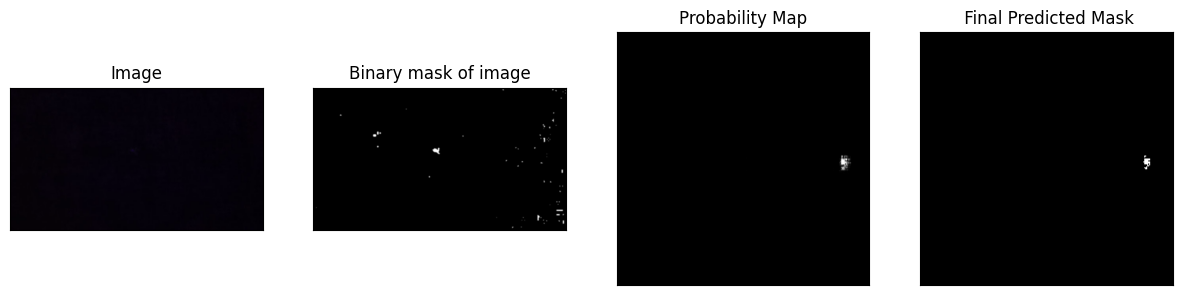

In [150]:
import random
import matplotlib.pyplot as plt

# Let's take a random training example
idx = random.randint(0, images.shape[0] - 1)
print (idx)

# Load the image
test_image = dataset[idx]["image"]
true_mask = dataset[idx]["masks"]  # Assuming the key for the true mask is "mask"

# Get the box prompt based on the ground truth segmentation map
ground_truth_mask = np.array(dataset[idx]["masks"])
prompt = promptbox(ground_truth_mask)

# Prepare the image + box prompt for the model
inputs = processor(test_image, input_boxes=[[prompt]], return_tensors="pt")

# Move the input tensor to the GPU if it's not already there
inputs = {k: v.to(device) for k, v in inputs.items()}

fabricmodel.eval()

# Forward pass
with torch.no_grad():
    outputs = fabricmodel(**inputs, multimask_output=False)

# Apply sigmoid
prob = torch.sigmoid(outputs.pred_masks.squeeze(1))
# Convert soft mask to hard mask
prob = prob.cpu().numpy().squeeze()
seg = (prob > 0.5).astype(np.uint8)

# Ensure seg is a 2D grayscale image
if seg.ndim == 3 and seg.shape[0] == 1:
    seg = np.squeeze(seg, axis=0)  # Squeeze the first dimension

# Select one of the probability maps
prob_selected = prob[0]  # Selecting the first probability map

fig, axes = plt.subplots(1, 4, figsize=(15, 6))

# Plot the first image on the left
axes[0].imshow(np.array(test_image), cmap='gray')  # Assuming the first image is grayscale
axes[0].set_title("Image")

# Plot the second image on the right
axes[3].imshow(seg[0], cmap='gray')  # Assuming the second image is grayscale
axes[3].set_title(" Final Predicted Mask")

# Plot the second image on the right
axes[2].imshow(prob_selected, cmap='gray')  # Assuming the second image is grayscale
axes[2].set_title("Probability Map")

# Plot the second image on the right
axes[1].imshow(true_mask, cmap='jet')  # Assuming the second image is grayscale
axes[1].set_title("Binary mask of image")
# Hide axis ticks and labels
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

# Display the images side by side
plt.show()
